# Lesson 2

## Generic AI

AI is just a function, with lots of parameters we can change, which takes an input and produces an output.

<img alt="" width="500" caption="Machine Learning Schematic" src="../data/lesson_images/ML_Schematic.png" id="ML_Schematic"/>

When we train an AI model, we measure the distance between the AI model output and the correct output - this is called the **loss**. We then adjust the parameters to make the model output a little closer to the correct ouput.

<img alt="" width="500" caption="Training Machine Learning Schematic" src="../data/lesson_images/ML_Training_Schematic.png" id="ML_Training_Schematic"/>

Remember the loss from lesson 1?

<img alt="" width="500" caption="The loss from our height-shoe-size AI" src="../data/lesson_images/loss.png" id="loss"/>

## Single Layer Perceptron

<img alt="Natural and artificial neurons" width="500" caption="Natural and artificial neurons" src="../data/lesson_images/chapter7_neuron.png" id="neuron"/>

Inspired by real neurones - multiple incoming signals arrive at different dendrites, with different sensitivity (**weight**). If they add together in the right combination, the neurone fires.

Let's build a simple neural net - the Rosenblatt perceptron - to read handwritten numbers. It will have 10 neurones, one for each number from 0...9 that we want to detect. The right neurone should turn on for the right number. 

Our Perceptron will "see" images of numbers (from the MNIST public training set) which are 28x28 = 784 pixels. So each neurone will have 784 dendrites - one for each pixel in the image - and each dendrite will have its own sensitivity to each pixel, called the **weight**. 

Each neurone will also have a total sensitivity which decides how easily it is turned on by the pixels. This is called the **bias** (which has more than one meaning in AI - ask me about it!).

In total our Perceptron model will have 784x10 = 7840 **weights** and 1x10 = 10 **biases**. So it has 7850 total parameters it must learn.

Today we will only make our perceptron learn how to recognise two numbers - 3 and 7 - using two neurones. This means our model only needs 784x2 = 1568 weights and 1x2 = 2 biases for a total of 1570 parameters. This will be approximately 5 times faster to train than learning all 10 numbers.

In [609]:
import fastbook
fastbook.setup_book()

In [610]:
from fastai.vision.all import *
from fastbook import *

In [611]:
path = untar_data(URLs.MNIST_SAMPLE) # Download the MNIST training images

In [612]:
path.ls()

(#3) [Path('/home/harvey/.fastai/data/mnist_sample/labels.csv'),Path('/home/harvey/.fastai/data/mnist_sample/valid'),Path('/home/harvey/.fastai/data/mnist_sample/train')]

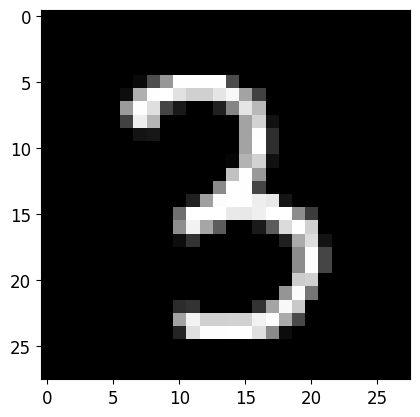

In [626]:
# Feel free to change this code

test_image_path = (path/'valid'/'3').ls().sorted()[0] # Try chanigng the 3 to another number and see what happens
test_image = Image.open(test_image_path)
test_image_tensor = tensor(test_image).view(-1, 28*28).float()/255
plt.imshow(test_image, cmap='gray')

In [614]:
# DO NOT CHANGE THIS 

# This code opens up all of our images and puts them into two big lists
# We use a library called 'torch' becuase it does it in a way that allows
# ..the computer to make very fast calculations

neurone_labels = ['3', '7'] # We are only going to train the model to recognise 3s and 7s


stacked_threes = torch.stack([tensor(Image.open(o)) for o in (path/'train'/'3').ls()]).float()/255 

stacked_sevens = torch.stack([tensor(Image.open(o)) for o in (path/'train'/'7').ls()]).float()/255 



stacked_sevens.shape, stacked_threes.shape # This shows the shape of our lists
# Our lists have around 6000 images, each of which is 28x28 pixels

(torch.Size([6265, 28, 28]), torch.Size([6131, 28, 28]))

In [615]:
# DO NOT CHANGE THIS CODE

# Here we combine our two lists into one big list
# We also take each 28x28 square image and turn it into a long list of 784 pixels

train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_x.shape

# Our list shape is (60000, 784) - 12000 total images squished into flat lists of 784 pixels

torch.Size([12396, 784])

In [616]:
# We do the same as above but only with three and seven so that training is faster
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_y = tensor([[1.0,0.0]]*len(stacked_threes) + [[0.0, 1.0]]*len(stacked_sevens))


In [617]:
class OneLayerPerceptron():

    def __init__(self, std=1.0):
        self.weights = (torch.randn(28*28, 2)*std).requires_grad_() # This 
        self.biases = (torch.randn(2)*std).requires_grad_() # This is the bias for the neurone

    def predict(self, x):
        # return F.softmax(((x @ self.weights) + self.biases).sigmoid(), dim=1)
        return F.softmax((x @ self.weights) + self.biases, dim=1) # This is the output of our model 


    def loss(self, input, training_output):
        return F.mse_loss(self.predict(input), training_output)
    
    def train_one_step(self, input_batch, training_output_batch):

        x = input_batch
        y = training_output_batch

        loss = self.loss(x, y)
        loss.backward() # This calculates the gradients for our weights and biases
        with torch.no_grad(): # This means we are not calculating gradients for the next step
            self.weights -= self.weights.grad * 0.1 # This is the learning rate
            self.biases -= self.biases.grad * 0.1
        self.weights.grad.zero_()
        self.biases.grad.zero_()
        return loss.item()
    
    def get_batch(self, input, training_output, batch_size=64):
        idxs = torch.randint(0, len(input), (batch_size,))
        # print(f"Batch indices: {idxs}")  # Debugging line to check indices
        return input[idxs], training_output[idxs]
    
    def train(self, input, training_data, cycles, batch_size=64):
        for i in range(cycles):
            input_batch, training_output_batch = self.get_batch(input, training_data, batch_size)
            loss = self.train_one_step(input_batch, training_output_batch)
            correct_percentage = (self.predict(input_batch).argmax(dim=1) == training_output_batch.argmax(dim=1)).float().mean().item()
            if i % 20 == 0:
                print(f"Cycle {i}, Loss: {loss:.4f}, Accuracy: {correct_percentage:.2%}")

In [638]:

model = OneLayerPerceptron() # Create a model with 784 inputs and 2 outputs (for the two neurones)

**Remember the test number from earlier?** Let's see if our model can predict the right answer...

The model predicts that the number is: 7


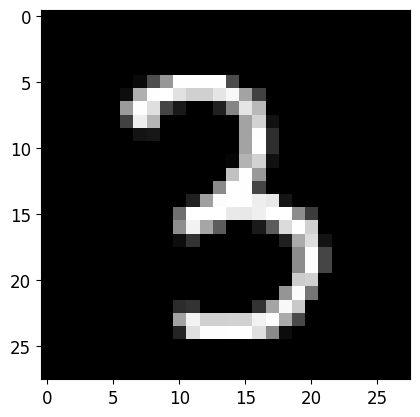

In [619]:
# DO NOT CHANGE THIS CODE

# Remember the test image we opened earlier? Let's see if our model can predict what number it is!
print(f'The model predicts that the number is: {neurone_labels[model.predict(test_image_tensor).argmax(dim=1).item()]}')
plt.imshow(test_image, cmap='gray')

**The prediction is completely wrong!** This is because we haven't *trained* the model yet... 

In [639]:
model.train(train_x, train_y, 1000, batch_size=64)


Cycle 0, Loss: 0.3017, Accuracy: 67.19%
Cycle 20, Loss: 0.2527, Accuracy: 71.88%
Cycle 40, Loss: 0.3499, Accuracy: 62.50%
Cycle 60, Loss: 0.1592, Accuracy: 82.81%
Cycle 80, Loss: 0.1440, Accuracy: 84.38%
Cycle 100, Loss: 0.1882, Accuracy: 78.12%
Cycle 120, Loss: 0.1031, Accuracy: 87.50%


Cycle 140, Loss: 0.0745, Accuracy: 92.19%
Cycle 160, Loss: 0.1267, Accuracy: 82.81%
Cycle 180, Loss: 0.0641, Accuracy: 93.75%
Cycle 200, Loss: 0.1296, Accuracy: 84.38%
Cycle 220, Loss: 0.0908, Accuracy: 89.06%
Cycle 240, Loss: 0.0856, Accuracy: 89.06%
Cycle 260, Loss: 0.0821, Accuracy: 92.19%
Cycle 280, Loss: 0.0334, Accuracy: 96.88%
Cycle 300, Loss: 0.0853, Accuracy: 90.62%
Cycle 320, Loss: 0.0666, Accuracy: 92.19%
Cycle 340, Loss: 0.1359, Accuracy: 84.38%
Cycle 360, Loss: 0.0754, Accuracy: 92.19%
Cycle 380, Loss: 0.0779, Accuracy: 90.62%
Cycle 400, Loss: 0.0849, Accuracy: 90.62%
Cycle 420, Loss: 0.1192, Accuracy: 85.94%
Cycle 440, Loss: 0.1193, Accuracy: 87.50%
Cycle 460, Loss: 0.0761, Accuracy: 92.19%
Cycle 480, Loss: 0.0985, Accuracy: 89.06%
Cycle 500, Loss: 0.0457, Accuracy: 95.31%
Cycle 520, Loss: 0.0577, Accuracy: 93.75%
Cycle 540, Loss: 0.0681, Accuracy: 92.19%
Cycle 560, Loss: 0.0653, Accuracy: 92.19%
Cycle 580, Loss: 0.0439, Accuracy: 95.31%
Cycle 600, Loss: 0.0571, Accuracy:

**If the final accuracy above is less than 92% then you should run the training again**

**If running the training again doesn't result in rapid improvement towards 90% then reset the model!**

Now let's see what the AI model thinks our test number is...



Prediction: 3, Confidence: 0.99


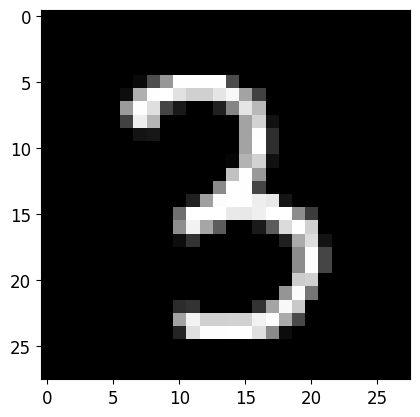

In [629]:
# DO NOT CHANGE THIS CODE
prediction = model.predict(test_image_tensor)

print(f'Prediction: {neurone_labels[prediction.argmax(dim=1).item()]}, Confidence: {prediction.max().item():.2f}')
plt.imshow(test_image, cmap='gray')

**Draw a number 3 or 7 yourself, take a photo and upload it. Use the below code to see what our trained AI model thinks the number is.**

In [622]:
# DO NOT CHANGE THIS CODE

# This is some helper code to load your photo

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def load_and_preprocess_np(image_path, crop_box=None):
    """
    Load an image, optionally crop, resize to 28×28 grayscale,
    normalize to [0,1], flatten to (784,), and display the image.
    """
    # Load and optional crop
    img = Image.open(image_path)
    if crop_box:
        img = img.crop(crop_box)
    # Grayscale & resize
    img = img.convert('L').resize((28,28), resample=Image.LANCZOS)
    # Normalize to [0,1]
    arr = np.array(img, dtype=np.float32) / 255.0  # shape (28,28)
    arr = 1.0 - arr  # Invert the image (white becomes black and vice versa)

    # Display the processed image
    plt.figure(figsize=(3,3))
    plt.imshow(arr, cmap='gray', vmin=0, vmax=1)
    plt.title('Processed 28×28 Image')
    plt.axis('off')
    plt.show()

    # Flatten to (784,)
    flat = arr.ravel()
    return flat



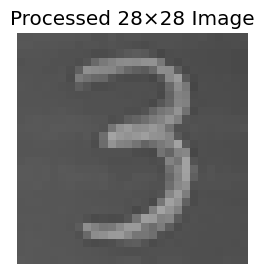

The trained AI model predicts that the number is: 3, with confidence 1.00


In [623]:
# Change this code to open your own photo

# Save your photo in the lesson_images folder and give it a name like "my_number.jpg"

# Change phone_crop.jpg to the name of your photo

flat_vector = load_and_preprocess_np('../data/lesson_images/phone_crop.jpg') 

print(f'The trained AI model predicts that the number is: {neurone_labels[model.predict(tensor(flat_vector).view(-1, 28*28)).argmax(dim=1).item()]}, \
with confidence {model.predict(tensor(flat_vector).view(-1, 28*28)).max().item():.2f}')

## Neural Nets and Deep Learning

The single layer perceptron we made above only has one layer of neurones. However, a real brain (and real **deep** learning models) use many many layers, with the axon terminals from one layer connecting to the dendrites of the next layer.

<img alt="Single layer perceptron diagram" width="500" caption="Single layer perceptron" src="../data/lesson_images/rosenblattPerceptron.png" id="rosenblattPerceptron"/>

<img alt="Deep perceptron diagram" width="500" caption="Deep perceptron" src="../data/lesson_images/deepPerceptron.png" id="deepPerceptron"/>

## Convolutional Neural Networks (CNNs)

If we plot our single layer perceptron weights as an image, we see they look a lot like the numbers we're trying to detect!

In [624]:
# DO NOT CHANGE THIS CODE

# This is just a helper function to make our plot have higher contrast

import numpy as np

def increase_contrast(img: np.ndarray, low_percentile: float = 2, high_percentile: float = 98) -> np.ndarray:
    """
    This is just a function to increase the contrast of a single-channel image
    """
    # Compute percentile cutoffs
    low, high = np.percentile(img, (low_percentile, high_percentile))
    # Stretch and clip
    stretched = (img - low) / (high - low)
    stretched = np.clip(stretched, 0.0, 1.0)
    return stretched

# Example usage:
# Assuming weight_imgs[0] is your (28,28) weight image:
# enhanced_img = increase_contrast(weight_imgs[0], low_percentile=1, high_percentile=99)



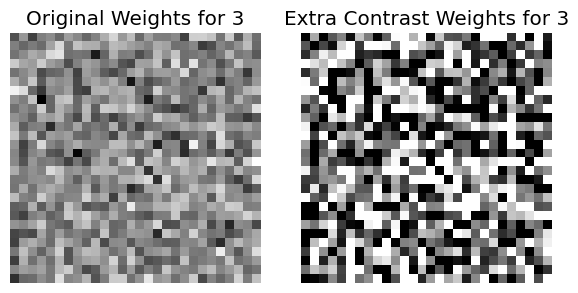

In [625]:
# To visualize before/after:
import matplotlib.pyplot as plt

# 1) Grab the learned weights 
W = model.weights.detach().cpu().numpy()

# 2) Turn each neuron’s weight‐vector into a 28×28 image
weight_imgs = [W[:, i].reshape(28, 28) for i in range(W.shape[1])]
original = weight_imgs[0] 
enhanced = increase_contrast(original, 20, 80)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
ax1.imshow(original, cmap='gray')
ax1.set_title('Original Weights for 3')
ax1.axis('off')
ax2.imshow(enhanced, cmap='gray')
ax2.set_title('Extra Contrast Weights for 3')
ax2.axis('off')
plt.tight_layout()
plt.show()

**Your version of the weights does not look like the number 3!** There is a complicated reason why - ask me!


<img src="../data/lesson_images/chapter9_conv_basic.png" id="basic_conv" caption="Applying a kernel to one location" alt="Applying a kernel to one location" width="700">

<img alt="A 4×4 kernel with 5×5 input and 2 pixels of padding" width="700" caption="A 4×4 kernel with 5×5 input and 2 pixels of padding (courtesy of Vincent Dumoulin and Francesco Visin)" id="four_by_five_conv" src="../data/lesson_images/att_00029.png">

<img src="../data/lesson_images/convolutionExample.png" id="convolutionExample" caption="Applying a kernel to a whole image" alt="Example of a convolution working" width="700">

<img src="../data/lesson_images/layer1.png" alt="Activations of the first layer of a CNN" width="300" caption="Activations of the first layer of a CNN (courtesy of Matthew D. Zeiler and Rob Fergus)" id="img_layer1">


<img src="../data/lesson_images/layer2.png" alt="Activations of the second layer of a CNN" width="800" caption="Activations of the second layer of a CNN (courtesy of Matthew D. Zeiler and Rob Fergus)" id="img_layer2">

<img src="../data/lesson_images/chapter2_layer3.PNG" alt="Activations of the third layer of a CNN" width="800" caption="Activations of the third layer of a CNN (courtesy of Matthew D. Zeiler and Rob Fergus)" id="img_layer3">

<img src="../data/lesson_images/chapter2_layer4and5.PNG" alt="Activations of layers 4 and 5 of a CNN" width="800" caption="Activations of layers 4 and 5 of a CNN (courtesy of Matthew D. Zeiler and Rob Fergus)" id="img_layer4">